#### "Monte Carlo simulation of the Martingale strategy: Speedup with Numba" v1.01

Author: Vlad C.

Github username: ET-DS

## Introduction

This notebook was created in order to test the performance of the Numba package.


All info on the package can be found on the [official website.](https://numba.pydata.org/)


For the test, I wrote a simple code which performs a Monte Carlo simulation of the Martingale strategy. 


The explanation of the Martingale strategy can be found [here.](https://en.wikipedia.org/wiki/Martingale_(betting_system))


The objective is to demonstrate the speedup with Numba package and, for the fun, how the Martingale Strategy fails in most cases.

### A brief explanation of what this notebook does


You start off with an __initial bank__ of £1000. Your goal is to increase your bank by playing a simple game of roulette, which can be found in any casino. But you can only bet on whether the next outcome of the roulette game will be a red or a black number. If you predict correctly the colour of the next outcome, you will gain 2x of your bet.


We'll play with a European-style layout with a single zero:

<img src="http://www.roulettestrategy.net/wp-content/uploads/2016/07/European-Roulette-Table.png" alt="European Layout example" title="Roulette layout" />


With this layour, there are 18 red numbers, 18 black numbers and a 0, which always yields a loss for us. The probabilities are as follows:

- Probability of the red outcome: 48,65%
- Probability of the black outcome: 48,65%
- Probability of the "zero" outcome: 2,70%


The Martingale strategy tries to get a "guaranteed" gain by doubling the bet after each loss. If your bet is correct (you predicted red and the outcome was indeed red), then you will gain 2x of your bet. But if your prediction was wrong, then, in order to compensate your previous losses and still get a positive gain, you will double your bet and try again to win. The idea is to double your bets until you finally win, and then reinitilize your bet to the initial one. As an example:


You first bet £1 on red, the outcome is black, so you lost. Now, you double your bet, so now you bet £2 on red, and you lose again. You bet £4 on red, and, how unlucky, you just lost 3 times in a row. You bet £8 on red, and, finally, you won, you get £16. But what is the profit of this sequence of bets? You lost £1 + £2 + £4 + £8 = £15 (the sum of your 4 bets), and you won £16, so your net gain is £1. That's the idea of the strategy: no matter how many losses in a row you had, by doubling your bet each time, you will eventually win and compensate your previous losses. Sounds easy, right?


__There's a catch, obviously:__ If you lose, for example, 10 times in a row, you will have to bet £2048 to continue playing. So, and inital bet of £1 escalates very quickly to some ridiculous numbers. The amount of money you lose by predicting the wrong outcome __n__ times in a row can be found with the formula:

$$ f(x) = 2^{(n+1)}-1 $$


So, if you get really unlucky, you will end up losing your whole bank. But how likely is it to lose your entire bank? By choosing a really small initial bet, some people would say that it's extremely unlikely to lose everything. Let's test a very "safe" strategy: we will start off with £1000, our goal will be to increase our bank to £10000, and our initial bet will be just 1 penny (£0.01). It will take a lot of time to get to our goal, but with such a small bet we should have at least some margin of safety. But will it be enough?

In [1]:
import numpy as np
import pandas as pd

import numba
from numba import jit
import random

import matplotlib.pyplot as plt
import seaborn
seaborn.set(color_codes=True)
# %matplotlib notebook

#from itertools import cycle
import time

pd.options.display.float_format = '{:.0f}'.format

We will have 2 functions: "simulate" and "simulate_numba". Their code is 100% identical, the only difference is that "simulate_numba" will be improved by Numba (notice the decorator of the function - "@jit(nopython=True)"). Just 1 line of code and some constraints to be respected will give us a significant performance boost for our simple function. 

In [2]:
def simulate(iterations=10, bet=1, initial_bank=100000, win=1000000, seed=9):
    np.random.seed(seed)
    
    steps = []
    max_bets = []
    max_banks = []
    winners = []
    wbanks = []
    lbanks = []
    
    for i in range(iterations):
        
        bank = initial_bank
        current_bet = bet
        max_bank = 0
        max_bet = 0
        choice = 1
        step = 0
        winner = 0
        outcomes = np.array([1]*18 + [2]*18 + [0])
        np.random.shuffle(outcomes)
        banks = []

        while bank > 0 and bank < win:
            if bank > max_bank:
                max_bank = bank
            if current_bet > bank:
                current_bet = bet
            if current_bet > max_bet:
                max_bet = current_bet
                
            bank -= current_bet
            
            if choice == outcomes[np.random.choice(outcomes.shape[0], 1, replace=False)[0]]:
                bank += current_bet*2
                current_bet = bet
                if bank >= win:
                    winner = 1
                    max_bank = win
                if choice == 1:
                    choice = 2
                else:
                    choice = 1
            else:
                current_bet *= 2
            step += 1
            banks.append(bank)
        
        steps.append(step)
        max_bets.append(max_bet)
        max_banks.append(max_bank)
        winners.append(winner)
        if len(wbanks) < 4:
            if winner == 1:
                wbanks.append(banks)
        if len(lbanks) < 4:
            if winner == 0:
                lbanks.append(banks)
        
    return steps , max_banks, max_bets , winners , wbanks , lbanks

In [3]:
@jit(nopython=True)
def simulate_numba(iterations=10, bet=1, initial_bank=100000, win=1000000, seed=9):
    np.random.seed(seed)
    
    steps = []
    max_bets = []
    max_banks = []
    winners = []
    wbanks = []
    lbanks = []
    
    for i in range(iterations):
        
        bank = initial_bank
        current_bet = bet
        max_bank = 0
        max_bet = 0
        choice = 1
        step = 0
        winner = 0
        outcomes = np.array([1]*18 + [2]*18 + [0])
        np.random.shuffle(outcomes)
        banks = []

        while bank > 0 and bank < win:
            if bank > max_bank:
                max_bank = bank
            if current_bet > bank:
                current_bet = bet
            if current_bet > max_bet:
                max_bet = current_bet
                
            bank -= current_bet
            
            if choice == outcomes[np.random.choice(outcomes.shape[0], 1, replace=False)[0]]:
                bank += current_bet*2
                current_bet = bet
                if bank >= win:
                    winner = 1
                    max_bank = win
                if choice == 1:
                    choice = 2
                else:
                    choice = 1
            else:
                current_bet *= 2
            step += 1
            banks.append(bank)
        
        steps.append(step)
        max_bets.append(max_bet)
        max_banks.append(max_bank)
        winners.append(winner)
        if len(wbanks) < 4:
            if winner == 1:
                wbanks.append(banks)
        if len(lbanks) < 4:
            if winner == 0:
                lbanks.append(banks)
        
    return steps , max_banks, max_bets , winners , wbanks , lbanks

### Part 1: 10k simulations with a 10x goal

Let's call the function "simulate" 20 times (as if there are 20 different people playing the game) and see how fast will it be executed.

In [4]:
start = time.time()
end = time.time()

steps, max_banks, max_bets, winners, wbanks, lbanks = simulate(iterations=20, bet=0.01, initial_bank=1000, win=10000)

end = time.time()
print('Execution time: {} s.'.format(int(end-start)))

Execution time: 307 s.


Now, let's see Numba in action.

In [5]:
start = time.time()

steps, max_banks, max_bets, winners, wbanks, lbanks = simulate_numba(iterations=20, bet=0.01, initial_bank=1000, win=10000)

end = time.time()
print('Execution time: {} s.'.format(int(end-start)))

Execution time: 1 s.


307 seconds vs 1 second: the result is self-explanatory. Don't forget that this boost was achieved with just 1 line of code and some constrainted programming of the functions (Numba doesn't support some functionalities, but most of the time it's not a big deal). Feel free to choose your own scenarios, increase the number of iterations and so on.


Now, let's see how fast 10000 iterations will be executed. For a better simulation, we could go with 100k or even 1 million simulations, but for the demonstration purposes 10k should be enough.

In [7]:
start = time.time()

steps, max_banks, max_bets, winners, wbanks, lbanks = simulate_numba(iterations=10000, bet=0.01, initial_bank=1000, win=10000)

end = time.time()
print('Execution time: {} s.'.format(int(end-start)))

Execution time: 840 s.


It took 14 minutes for 10000 iterations with my setup.

#### Now, the results... Let's print some stats!

In [8]:
print("Total number of games played: {}".format(len(steps)))
print("Steps on average:", int(np.mean(steps)))
print("Max Bets on average:", int(np.mean(max_bets)))
print("Max Banks on average:", int(np.mean(max_banks)))
print("\n")
print("Number of Winners:", sum(winners))
print("% of Winners: {}%".format(round(sum(winners)/len(steps) * 100, 2)))

Total number of games played: 10000
Steps on average: 342823
Max Bets on average: 641
Max Banks on average: 1890


Number of Winners: 110
% of Winners: 1.1%


In this simulation, 10000 people started off with £1000 and they were playing this game until they either reached £10000 or lost everything. Only 110 of them were lucky enough to achieve their goal (they multiplied their bank by 10). The others, though... They have lost everything. Let's visualize what happened for some of them.


#### (!) So the probability of winning in this game with a 10x goal is approximately 1%.


First, let's see how the banks of 4 lucky winners were growing over time (x axis - steps, y axis - bank at each step).

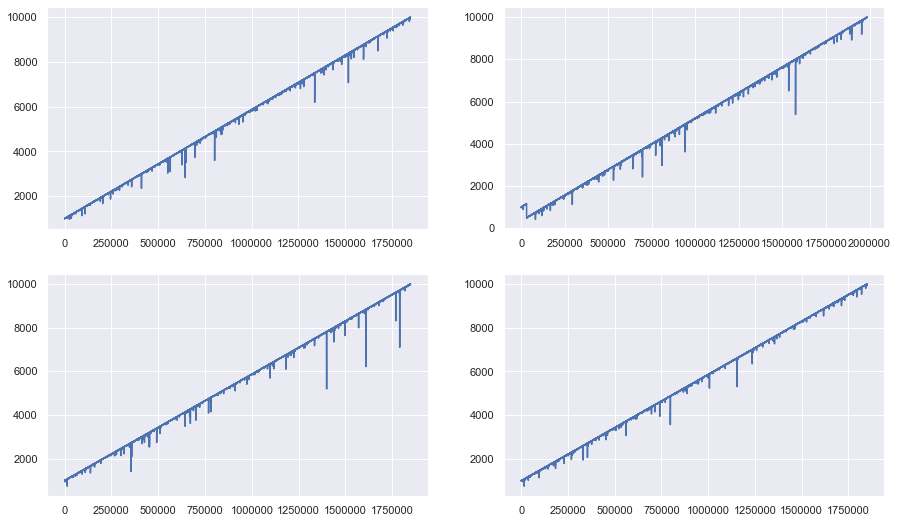

In [9]:
if len(wbanks) == 4:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 9))
    plot_index = 0

    for row in ax:
        for col in row:
            col.plot(wbanks[plot_index])
            plot_index += 1
    plt.show()
    
else:
    plt.plot(wbanks[0]);

It took them on average almost 2 million steps in order to achieve their goal. Obviously, in a real casino you won't be able to play for such a long time.


Now, the sad part... Let's see how 4 people lost their banks.

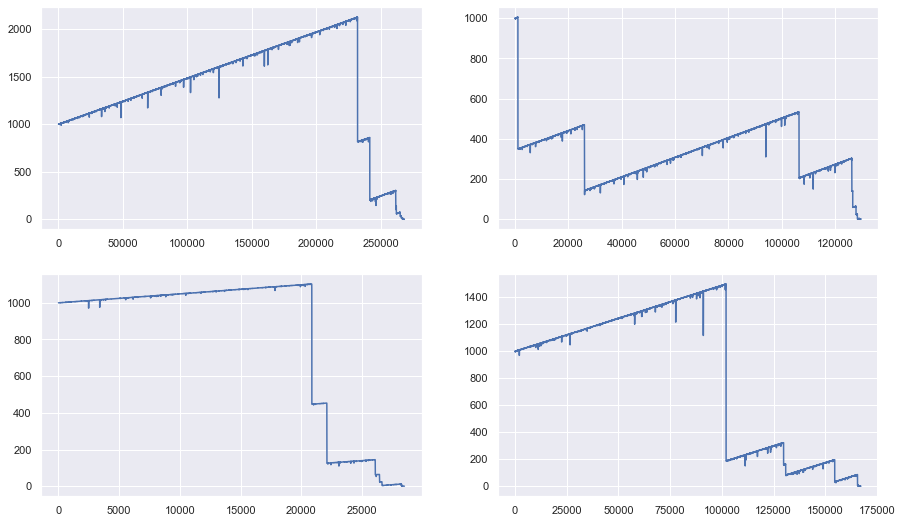

In [10]:
if len(lbanks) >= 4:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 9))
    plot_index = 0

    for row in ax:
        for col in row:
            col.plot(lbanks[plot_index])
            plot_index += 1
    plt.show()
    
else:
    plt.plot(lbanks[0]);

Even though the probability of losing, for example, 10 times in a row is extremely low (0.00074%), as you need to play millions of games in order to win, eventually most people end up losing everything because of a lose streak.


Let's see some stats:

In [11]:
df = pd.concat([pd.Series(steps), pd.Series(max_banks), pd.Series(max_bets)], axis=1)
df.columns = ['Steps', 'Max Bank', 'Max Bet']
df.describe()

,Steps,Max Bank,Max Bet
count,10000,10000,10000
mean,342823,1890,642
std,441456,1414,457
min,3865,1000,328
25%,102259,1151,328
50%,201593,1411,655
75%,386589,2005,655
max,6232026,10000,2621


The biggest bet someone placed was £2621, meaning that the unluckiest person lost 18 times in a row. This can be verified as follows (note that we divide by 100, because our initial bet was 1 penny):

$$ 2621 = \frac{(2^{18}-1)}{100} $$

The probability of losing 18 times in a row is about 0.0000023%. He will probably never play roulette ever again.


#### (!) BUT, our goal was probably too ridiculous. Making 10x of your initial bank isn't realistic. What about making 2x?

### Part 2: 100k simulations with a 2x goal

Let's try to simulate 100k games with inital bank £1000 and the goal of £2000. Just a 2x... Now, the odds should be in our favour, right? Well, not really...

In [12]:
start = time.time()

steps, max_banks, max_bets, winners, wbanks, lbanks = simulate_numba(iterations=100000, bet=0.01, initial_bank=1000, win=2000)

end = time.time()
print('Execution time: {} s.'.format(int(end-start)))

Execution time: 4702 s.


1 hour and 18 minutes for 100k iterations. It could probably run much faster with a more optimal code, but my objective was to write the simplest code possible and test it right away. The next step would be trying to optimize the "simulate" function with matrix operations, for example.

In [13]:
print("Total number of games played: {}".format(len(steps)))
print("Steps on average:", int(np.mean(steps)))
print("Max Bets on average:", int(np.mean(max_bets)))
print("Max Banks on average:", int(np.mean(max_banks)))
print("\n")
print("Number of Winners:", sum(winners))
print("% of Winners: {}%".format(round(sum(winners)/len(steps) * 100, 2)))

Total number of games played: 100000
Steps on average: 192843
Max Bets on average: 472
Max Banks on average: 1499


Number of Winners: 25818
% of Winners: 25.82%


Well, it seems like even with a 2x goal the odds of winning aren't that great: only 1 person out of 4 doubled the initial bank, all the others lost everything.

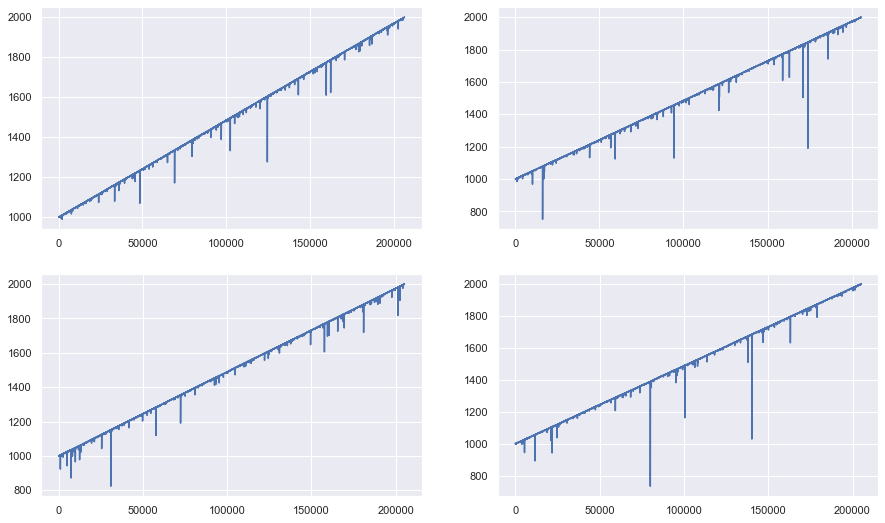

In [14]:
if len(wbanks) == 4:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 9))
    plot_index = 0

    for row in ax:
        for col in row:
            col.plot(wbanks[plot_index])
            plot_index += 1
    plt.show()
    
else:
    plt.plot(wbanks[0]);

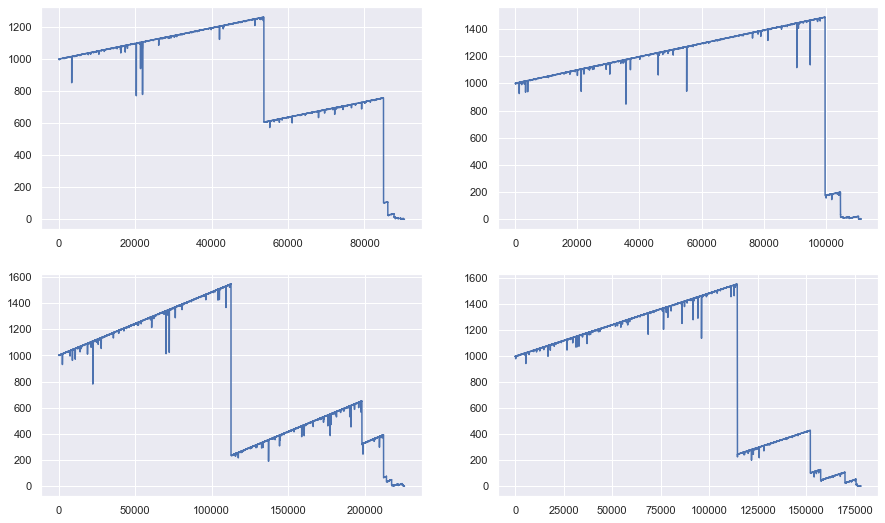

In [15]:
if len(lbanks) >= 4:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 9))
    plot_index = 0

    for row in ax:
        for col in row:
            col.plot(lbanks[plot_index])
            plot_index += 1
    plt.show()
    
else:
    plt.plot(lbanks[0]);

In [16]:
df = pd.concat([pd.Series(steps), pd.Series(max_banks), pd.Series(max_bets)], axis=1)
df.columns = ['Steps', 'Max Bank', 'Max Bet']
df.describe()

,Steps,Max Bank,Max Bet
count,100000,100000,100000
mean,192844,1500,473
std,124784,375,165
min,1609,1000,82
25%,100596,1149,328
50%,200674,1404,328
75%,216146,2000,655
max,1587889,2000,655


### Conclusion

Martingale strategy isn't much better than any form of lottery even with the assumptions made in this notebook which are obviously not true in real life.


- Here, we didn't take into account min and max bet limits. In real casinos, they exist, and these limits won't allow you to be as flexible and go as far away with bet doubling as we did.
- In order to win 10x of our initial bank, we needed to place 2 million bets. Just imagine how much time would it take in real life.
- We assumed that the probabilities of red/black/zero outcomes are the true probabilites of the random outcomes. In real life... We don't really know what happens behind the scenes, whether it's a real or, even worse, an online casino.

#### Bonus

As a bonus, let's check NumPy's np.random.choice function (and Numba, of course). We'll be getting random numbers 100 million times. If you would like to check it without Numba, you can uncomment the row in the next cell.

In [ ]:
outcomes = np.array([1]*18 + [2]*18 + [0])
np.random.shuffle(outcomes)
nb = 100000000

def check_random_outcomes():
    z = 0
    o = 0
    t = 0
    
    for i in range(nb):
        outcome = outcomes[np.random.choice(outcomes.shape[0], 1, replace=False)[0]]
        if outcome == 0:
            z+=1
        if outcome == 1:
            o+=1
        if outcome == 2:
            t+=1
    return z, o, t
            
start = time.time()

# zeros, ones, twos = check_random_outcomes()

end = time.time()
print('Execution time: {} s.'.format(int(end-start)))
        
print("0:", zeros, "    | Probability: {}%".format(round(zeros/nb*100, 1)))
print("Red:", ones, "   | Probability: {}%".format(round(ones/nb*100, 1)))
print("Black:", twos, "   | Probability: {}%".format(round(twos/nb*100, 1)))

In [2]:
outcomes = np.array([1]*18 + [2]*18 + [0])
np.random.shuffle(outcomes)
nb = 100000000

@jit(nopython=True)
def check_random_outcomes_numba():
    z = 0
    o = 0
    t = 0
    
    for i in range(nb):
        outcome = outcomes[np.random.choice(outcomes.shape[0], 1, replace=False)[0]]
        if outcome == 0:
            z+=1
        if outcome == 1:
            o+=1
        if outcome == 2:
            t+=1
    return z, o, t
            
start = time.time()

zeros, ones, twos = check_random_outcomes_numba()

end = time.time()
print('Execution time: {} s.'.format(int(end-start)))
        
print("0:", zeros, "        | Probability: {}%".format(round(zeros/nb*100, 1)))
print("Red:", ones, "     | Probability: {}%".format(round(ones/nb*100, 1)))
print("Black:", twos, "   | Probability: {}%".format(round(twos/nb*100, 1)))

Execution time: 68 s.
0: 2704044         | Probability: 2.7%
Red: 48643273      | Probability: 48.6%
Black: 48652683    | Probability: 48.7%
